In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff

from model import FixCapsNet

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"#"COVID-19"#"ISIC2019"#"skin_lesion"#
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}
# write = SummaryWriter()
#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [4]:
def get_data(trans_test='312'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)), #highlight
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "datasets","HAM10000")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx #label text to number
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4) #store `cla_dict` into json file
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [5]:
BatchSize = 64 #168#128#168 #modify from 168 to 64 to prevent GPU memory overflow
V_size = 31 #30#64
T_size = 31 
train_doc = "train525s8" #maybe a folder name
val_doc = "val525s8"
test_doc = "test_001"
learning_rate = 0.123
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.


In [6]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 141, 141]         124,544
              ReLU-2        [-1, 128, 141, 141]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
print(device)
pff(m_name="FixCaps",model=network,inputes=input_data)

cuda
+---------+-----------+----------+-------+
|  Model  | Params(M) | FLOPs(G) |  FPS  |
+---------+-----------+----------+-------+
| FixCaps |    0.26   |   2.48   | 39.04 |
+---------+-----------+----------+-------+


In [8]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(18, 18), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [9]:
# def_betas=(0.9, 0.999)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)
# optimizer = optim.AdamW(network.parameters(), lr=learning_rate, weight_decay=0.01)
#base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0,
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [10]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    # scaler = torch.cuda.amp.GradScaler()
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        # data, target =data.to(device), target_one_hot.to(device)
        # with torch.cuda.amp.autocast():
        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()        
        optimizer.step()
        optimizer.zero_grad()
        # scheduler.step()#AdamW            
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [11]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [12]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    # !mkdir -p ./tmp/{img_title}/{suf} #create `tmp` folder
    os.makedirs(f"./tmp/{img_title}/{suf}", exist_ok=True)
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:0104_163352
./tmp/HAM10000/0104_163352/best_HAM10000_0104_163352.pth


In [13]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  12389 KiB |  43770 KiB |  80481 KiB |  68091 KiB |
|       from large pool |  11384 KiB |  36943 KiB |  63809 KiB |  52425 KiB |
|       from small pool |   1005 KiB |   6827 KiB |  16671 KiB |  15666 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  12389 KiB |  43770 KiB |  80481 KiB |  68091 KiB |
|       from large pool |  11384 KiB |  36943 KiB |  63809 KiB |

In [16]:
num_epochs = 150

In [16]:
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.24332,ACC:0.62988
[128/128] Loss0.25285,ACC:0.64844
Train Epoch:[1] Loss:0.28658,Acc:0.64931,Best_train:0.64931
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:66.6%
Best_val:[66.6%]
[Train Epoch:[2]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20401,ACC:0.65991
[128/128] Loss0.19621,ACC:0.66663
Train Epoch:[2] Loss:0.23208,Acc:0.66752,Best_train:0.66752
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:69.781%
Best_val:[69.781%]
[Train Epoch:[3]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19039,ACC:0.66943
[128/128] Loss0.31193,ACC:0.66663
Train Epoch:[3] Loss:0.22620,Acc:0.66752,Best_train:0.66752
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:68.191%
Best_val:[69.781%]
[Train Epoch:[4]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23243,ACC:0.67163
[128/128] Loss0.21416,ACC:0.67065
Train Epoch:[4] Loss:0.22092,Acc:0.67156,Best_train:0.67156
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:71.869%
Best_val:[71.869%]
[Train Epoch:[5]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21176,ACC:0.68701
[128/128] Loss0.20434,ACC:0.67676
Train Epoch:[5] Loss:0.21541,Acc:0.67767,Best_train:0.67767
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:71.471%
Best_val:[71.869%]
[Train Epoch:[6]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19539,ACC:0.68604
[128/128] Loss0.20697,ACC:0.67810
Train Epoch:[6] Loss:0.21439,Acc:0.67901,Best_train:0.67901
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:71.67%
Best_val:[71.869%]
[Train Epoch:[7]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17545,ACC:0.67334
[128/128] Loss0.22341,ACC:0.67688
Train Epoch:[7] Loss:0.21444,Acc:0.67779,Best_train:0.67901
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:73.559%
Best_val:[73.559%]
[Train Epoch:[8]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21931,ACC:0.68018
[128/128] Loss0.19158,ACC:0.67957
Train Epoch:[8] Loss:0.21573,Acc:0.68048,Best_train:0.68048
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:75.149%
Best_val:[75.149%]
[Train Epoch:[9]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23052,ACC:0.68140
[128/128] Loss0.15350,ACC:0.67700
Train Epoch:[9] Loss:0.21633,Acc:0.67791,Best_train:0.68048
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:74.652%
Best_val:[75.149%]
[Train Epoch:[10]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.22442,ACC:0.69214
[128/128] Loss0.18132,ACC:0.68103
Train Epoch:[10] Loss:0.21671,Acc:0.68195,Best_train:0.68195
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:73.757%
Best_val:[75.149%]
[Train Epoch:[11]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.26511,ACC:0.68652
[128/128] Loss0.22028,ACC:0.68115
Train Epoch:[11] Loss:0.21465,Acc:0.68207,Best_train:0.68207
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:74.851%
Best_val:[75.149%]
[Train Epoch:[12]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.22154,ACC:0.68652
[128/128] Loss0.20677,ACC:0.68457
Train Epoch:[12] Loss:0.21197,Acc:0.68549,Best_train:0.68549
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:74.851%
Best_val:[75.149%]
[Train Epoch:[13]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21231,ACC:0.68750
[128/128] Loss0.17995,ACC:0.68958
Train Epoch:[13] Loss:0.20792,Acc:0.69050,Best_train:0.69050
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:72.664%
Best_val:[75.149%]
[Train Epoch:[14]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19619,ACC:0.68652
[128/128] Loss0.20644,ACC:0.69080
Train Epoch:[14] Loss:0.20294,Acc:0.69172,Best_train:0.69172
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.243%
Best_val:[76.243%]
[Train Epoch:[15]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16463,ACC:0.69165
[128/128] Loss0.23988,ACC:0.69482
Train Epoch:[15] Loss:0.20040,Acc:0.69576,Best_train:0.69576
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.541%
Best_val:[76.541%]
[Train Epoch:[16]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23105,ACC:0.70068
[128/128] Loss0.20877,ACC:0.70081
Train Epoch:[16] Loss:0.19871,Acc:0.70175,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:76.64%
Best_val:[76.64%]
[Train Epoch:[17]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16091,ACC:0.69971
[128/128] Loss0.23740,ACC:0.69800
Train Epoch:[17] Loss:0.19896,Acc:0.69894,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.628%
Best_val:[78.628%]
[Train Epoch:[18]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21924,ACC:0.69849
[128/128] Loss0.25268,ACC:0.69690
Train Epoch:[18] Loss:0.20262,Acc:0.69784,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.318%
Best_val:[80.318%]
[Train Epoch:[19]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23856,ACC:0.69556
[128/128] Loss0.16658,ACC:0.69556
Train Epoch:[19] Loss:0.20033,Acc:0.69649,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.231%
Best_val:[80.318%]
[Train Epoch:[20]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19465,ACC:0.70166
[128/128] Loss0.20826,ACC:0.69604
Train Epoch:[20] Loss:0.20443,Acc:0.69698,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:79.423%
Best_val:[80.318%]
[Train Epoch:[21]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15672,ACC:0.69727
[128/128] Loss0.18412,ACC:0.69348
Train Epoch:[21] Loss:0.20408,Acc:0.69441,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.032%
Best_val:[80.318%]
[Train Epoch:[22]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16505,ACC:0.70459
[128/128] Loss0.21630,ACC:0.69788
Train Epoch:[22] Loss:0.20075,Acc:0.69881,Best_train:0.70175
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[81.213%]
[Train Epoch:[23]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.22643,ACC:0.70215
[128/128] Loss0.21932,ACC:0.70178
Train Epoch:[23] Loss:0.19606,Acc:0.70273,Best_train:0.70273
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[81.213%]
[Train Epoch:[24]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21061,ACC:0.71582
[128/128] Loss0.17276,ACC:0.71948
Train Epoch:[24] Loss:0.18971,Acc:0.72045,Best_train:0.72045
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.3%
Best_val:[83.3%]
[Train Epoch:[25]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18904,ACC:0.72119
[128/128] Loss0.18291,ACC:0.71790
Train Epoch:[25] Loss:0.18760,Acc:0.71886,Best_train:0.72045
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[83.4%]
[Train Epoch:[26]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17101,ACC:0.72925
[128/128] Loss0.19425,ACC:0.72388
Train Epoch:[26] Loss:0.18613,Acc:0.72485,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[83.4%]
[Train Epoch:[27]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17775,ACC:0.72070
[128/128] Loss0.17036,ACC:0.71753
Train Epoch:[27] Loss:0.18874,Acc:0.71849,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.499%
Best_val:[83.499%]
[Train Epoch:[28]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18986,ACC:0.72046
[128/128] Loss0.23435,ACC:0.71912
Train Epoch:[28] Loss:0.18939,Acc:0.72008,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[84.692%]
[Train Epoch:[29]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17168,ACC:0.71973
[128/128] Loss0.20598,ACC:0.71729
Train Epoch:[29] Loss:0.19038,Acc:0.71825,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[86.581%]
[Train Epoch:[30]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14268,ACC:0.70557
[128/128] Loss0.16805,ACC:0.70703
Train Epoch:[30] Loss:0.19376,Acc:0.70798,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[86.581%]
[Train Epoch:[31]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23340,ACC:0.71753
[128/128] Loss0.17980,ACC:0.70898
Train Epoch:[31] Loss:0.19510,Acc:0.70994,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.014%
Best_val:[86.581%]
[Train Epoch:[32]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19357,ACC:0.71924
[128/128] Loss0.18982,ACC:0.71338
Train Epoch:[32] Loss:0.19140,Acc:0.71434,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.909%
Best_val:[86.581%]
[Train Epoch:[33]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19843,ACC:0.72168
[128/128] Loss0.17094,ACC:0.71802
Train Epoch:[33] Loss:0.18778,Acc:0.71898,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:80.915%
Best_val:[86.581%]
[Train Epoch:[34]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19907,ACC:0.72729
[128/128] Loss0.14925,ACC:0.72302
Train Epoch:[34] Loss:0.18410,Acc:0.72399,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[86.581%]
[Train Epoch:[35]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18697,ACC:0.72974
[128/128] Loss0.20510,ACC:0.72363
Train Epoch:[35] Loss:0.18203,Acc:0.72461,Best_train:0.72485
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[86.581%]
[Train Epoch:[36]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18037,ACC:0.72388
[128/128] Loss0.15678,ACC:0.72571
Train Epoch:[36] Loss:0.18091,Acc:0.72668,Best_train:0.72668
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[86.581%]
[Train Epoch:[37]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12205,ACC:0.72827
[128/128] Loss0.20947,ACC:0.72400
Train Epoch:[37] Loss:0.18179,Acc:0.72497,Best_train:0.72668
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[86.779%]
[Train Epoch:[38]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20199,ACC:0.73022
[128/128] Loss0.16283,ACC:0.72522
Train Epoch:[38] Loss:0.18394,Acc:0.72619,Best_train:0.72668
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[86.779%]
[Train Epoch:[39]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16070,ACC:0.71924
[128/128] Loss0.17274,ACC:0.72705
Train Epoch:[39] Loss:0.18369,Acc:0.72803,Best_train:0.72803
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[86.779%]
[Train Epoch:[40]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.10947,ACC:0.73193
[128/128] Loss0.28112,ACC:0.72144
Train Epoch:[40] Loss:0.18651,Acc:0.72241,Best_train:0.72803
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.61%
Best_val:[86.779%]
[Train Epoch:[41]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21785,ACC:0.72070
[128/128] Loss0.20512,ACC:0.71558
Train Epoch:[41] Loss:0.18945,Acc:0.71654,Best_train:0.72803
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[87.575%]
[Train Epoch:[42]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23064,ACC:0.71924
[128/128] Loss0.21276,ACC:0.72144
Train Epoch:[42] Loss:0.18648,Acc:0.72241,Best_train:0.72803
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[87.575%]
[Train Epoch:[43]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19738,ACC:0.73169
[128/128] Loss0.16793,ACC:0.72839
Train Epoch:[43] Loss:0.18312,Acc:0.72937,Best_train:0.72937
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[87.575%]
[Train Epoch:[44]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16066,ACC:0.73584
[128/128] Loss0.17653,ACC:0.73438
Train Epoch:[44] Loss:0.17946,Acc:0.73536,Best_train:0.73536
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[87.575%]
[Train Epoch:[45]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21168,ACC:0.73999
[128/128] Loss0.15218,ACC:0.73340
Train Epoch:[45] Loss:0.17848,Acc:0.73438,Best_train:0.73536
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.773%
Best_val:[87.773%]
[Train Epoch:[46]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16636,ACC:0.74341
[128/128] Loss0.20054,ACC:0.73694
Train Epoch:[46] Loss:0.17943,Acc:0.73793,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:88.27%
Best_val:[88.27%]
[Train Epoch:[47]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12590,ACC:0.72729
[128/128] Loss0.15281,ACC:0.73486
Train Epoch:[47] Loss:0.17703,Acc:0.73585,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[88.27%]
[Train Epoch:[48]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20020,ACC:0.73730
[128/128] Loss0.16263,ACC:0.73157
Train Epoch:[48] Loss:0.17917,Acc:0.73255,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.089%
Best_val:[88.27%]
[Train Epoch:[49]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19553,ACC:0.73486
[128/128] Loss0.18214,ACC:0.72974
Train Epoch:[49] Loss:0.18160,Acc:0.73072,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[88.27%]
[Train Epoch:[50]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.22731,ACC:0.72510
[128/128] Loss0.16797,ACC:0.72693
Train Epoch:[50] Loss:0.18368,Acc:0.72791,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[88.27%]
[Train Epoch:[51]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14768,ACC:0.72412
[128/128] Loss0.17659,ACC:0.72241
Train Epoch:[51] Loss:0.18535,Acc:0.72338,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[88.27%]
[Train Epoch:[52]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17693,ACC:0.72559
[128/128] Loss0.17170,ACC:0.72449
Train Epoch:[52] Loss:0.18497,Acc:0.72546,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.698%
Best_val:[88.27%]
[Train Epoch:[53]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16260,ACC:0.73535
[128/128] Loss0.20189,ACC:0.73047
Train Epoch:[53] Loss:0.18167,Acc:0.73145,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.089%
Best_val:[88.27%]
[Train Epoch:[54]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15100,ACC:0.72510
[128/128] Loss0.18469,ACC:0.73035
Train Epoch:[54] Loss:0.17719,Acc:0.73133,Best_train:0.73793
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.288%
Best_val:[88.27%]
[Train Epoch:[55]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16778,ACC:0.74634
[128/128] Loss0.21250,ACC:0.73804
Train Epoch:[55] Loss:0.17517,Acc:0.73903,Best_train:0.73903
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.674%
Best_val:[88.27%]
[Train Epoch:[56]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15229,ACC:0.74561
[128/128] Loss0.21650,ACC:0.73853
Train Epoch:[56] Loss:0.17465,Acc:0.73952,Best_train:0.73952
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.475%
Best_val:[88.27%]
[Train Epoch:[57]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17024,ACC:0.73999
[128/128] Loss0.13777,ACC:0.74036
Train Epoch:[57] Loss:0.17336,Acc:0.74135,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.276%
Best_val:[88.27%]
[Train Epoch:[58]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20526,ACC:0.72534
[128/128] Loss0.15363,ACC:0.73401
Train Epoch:[58] Loss:0.17680,Acc:0.73500,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.575%
Best_val:[88.27%]
[Train Epoch:[59]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19136,ACC:0.73779
[128/128] Loss0.21052,ACC:0.73523
Train Epoch:[59] Loss:0.17931,Acc:0.73622,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[88.27%]
[Train Epoch:[60]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12902,ACC:0.72778
[128/128] Loss0.19807,ACC:0.72632
Train Epoch:[60] Loss:0.18316,Acc:0.72729,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[88.27%]
[Train Epoch:[61]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15854,ACC:0.73950
[128/128] Loss0.20899,ACC:0.72742
Train Epoch:[61] Loss:0.18368,Acc:0.72840,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.487%
Best_val:[88.27%]
[Train Epoch:[62]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16953,ACC:0.72778
[128/128] Loss0.22479,ACC:0.72522
Train Epoch:[62] Loss:0.18208,Acc:0.72619,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.99%
Best_val:[88.27%]
[Train Epoch:[63]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20779,ACC:0.73389
[128/128] Loss0.19727,ACC:0.73157
Train Epoch:[63] Loss:0.17796,Acc:0.73255,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[88.27%]
[Train Epoch:[64]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12961,ACC:0.74927
[128/128] Loss0.20793,ACC:0.73584
Train Epoch:[64] Loss:0.17445,Acc:0.73683,Best_train:0.74135
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[88.27%]
[Train Epoch:[65]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18211,ACC:0.74487
[128/128] Loss0.19972,ACC:0.74536
Train Epoch:[65] Loss:0.17033,Acc:0.74636,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.879%
Best_val:[88.27%]
[Train Epoch:[66]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17802,ACC:0.74731
[128/128] Loss0.18725,ACC:0.74500
Train Epoch:[66] Loss:0.17074,Acc:0.74600,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.475%
Best_val:[88.27%]
[Train Epoch:[67]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19477,ACC:0.74243
[128/128] Loss0.13787,ACC:0.74500
Train Epoch:[67] Loss:0.17110,Acc:0.74600,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[88.27%]
[Train Epoch:[68]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18717,ACC:0.74023
[128/128] Loss0.15313,ACC:0.73767
Train Epoch:[68] Loss:0.17339,Acc:0.73866,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[88.27%]
[Train Epoch:[69]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16537,ACC:0.73633
[128/128] Loss0.16071,ACC:0.73889
Train Epoch:[69] Loss:0.17571,Acc:0.73989,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[88.27%]
[Train Epoch:[70]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16325,ACC:0.73047
[128/128] Loss0.20208,ACC:0.73718
Train Epoch:[70] Loss:0.17824,Acc:0.73817,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[88.27%]
[Train Epoch:[71]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.22249,ACC:0.72949
[128/128] Loss0.20552,ACC:0.72900
Train Epoch:[71] Loss:0.17923,Acc:0.72998,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[88.27%]
[Train Epoch:[72]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15001,ACC:0.73047
[128/128] Loss0.18295,ACC:0.73010
Train Epoch:[72] Loss:0.17873,Acc:0.73108,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[88.27%]
[Train Epoch:[73]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20709,ACC:0.75049
[128/128] Loss0.24476,ACC:0.74292
Train Epoch:[73] Loss:0.17499,Acc:0.74392,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[88.27%]
[Train Epoch:[74]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14107,ACC:0.74634
[128/128] Loss0.18361,ACC:0.74390
Train Epoch:[74] Loss:0.17157,Acc:0.74490,Best_train:0.74636
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[88.27%]
[Train Epoch:[75]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19692,ACC:0.75073
[128/128] Loss0.16331,ACC:0.74854
Train Epoch:[75] Loss:0.16817,Acc:0.74954,Best_train:0.74954
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[88.27%]
[Train Epoch:[76]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16320,ACC:0.75488
[128/128] Loss0.16409,ACC:0.75366
Train Epoch:[76] Loss:0.16582,Acc:0.75468,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.598%
Best_val:[88.27%]
[Train Epoch:[77]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16461,ACC:0.75439
[128/128] Loss0.15385,ACC:0.75098
Train Epoch:[77] Loss:0.16738,Acc:0.75199,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[88.27%]
[Train Epoch:[78]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12486,ACC:0.75269
[128/128] Loss0.17905,ACC:0.75171
Train Epoch:[78] Loss:0.16737,Acc:0.75272,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[88.27%]
[Train Epoch:[79]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15922,ACC:0.74048
[128/128] Loss0.20945,ACC:0.74316
Train Epoch:[79] Loss:0.17252,Acc:0.74416,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[88.27%]
[Train Epoch:[80]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18634,ACC:0.73438
[128/128] Loss0.19557,ACC:0.73560
Train Epoch:[80] Loss:0.17711,Acc:0.73658,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[88.27%]
[Train Epoch:[81]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17750,ACC:0.73560
[128/128] Loss0.15993,ACC:0.73865
Train Epoch:[81] Loss:0.17546,Acc:0.73964,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.294%
Best_val:[88.27%]
[Train Epoch:[82]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18844,ACC:0.74072
[128/128] Loss0.14302,ACC:0.73706
Train Epoch:[82] Loss:0.17710,Acc:0.73805,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[88.27%]
[Train Epoch:[83]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14952,ACC:0.74219
[128/128] Loss0.22973,ACC:0.74036
Train Epoch:[83] Loss:0.17270,Acc:0.74135,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:82.704%
Best_val:[88.27%]
[Train Epoch:[84]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23836,ACC:0.74146
[128/128] Loss0.22266,ACC:0.74683
Train Epoch:[84] Loss:0.16921,Acc:0.74783,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.698%
Best_val:[88.27%]
[Train Epoch:[85]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15285,ACC:0.75098
[128/128] Loss0.21570,ACC:0.75159
Train Epoch:[85] Loss:0.16748,Acc:0.75260,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[88.27%]
[Train Epoch:[86]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16129,ACC:0.75317
[128/128] Loss0.17367,ACC:0.75122
Train Epoch:[86] Loss:0.16511,Acc:0.75223,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[88.27%]
[Train Epoch:[87]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14121,ACC:0.75781
[128/128] Loss0.15550,ACC:0.75061
Train Epoch:[87] Loss:0.16503,Acc:0.75162,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[88.27%]
[Train Epoch:[88]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18933,ACC:0.75366
[128/128] Loss0.17899,ACC:0.75195
Train Epoch:[88] Loss:0.16774,Acc:0.75296,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[88.27%]
[Train Epoch:[89]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17014,ACC:0.74292
[128/128] Loss0.17392,ACC:0.74292
Train Epoch:[89] Loss:0.16970,Acc:0.74392,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.101%
Best_val:[88.27%]
[Train Epoch:[90]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20143,ACC:0.73364
[128/128] Loss0.19520,ACC:0.73901
Train Epoch:[90] Loss:0.17447,Acc:0.74001,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[88.27%]
[Train Epoch:[91]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23881,ACC:0.75244
[128/128] Loss0.19416,ACC:0.74072
Train Epoch:[91] Loss:0.17449,Acc:0.74172,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.101%
Best_val:[88.27%]
[Train Epoch:[92]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18487,ACC:0.74976
[128/128] Loss0.15702,ACC:0.74341
Train Epoch:[92] Loss:0.17350,Acc:0.74441,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.101%
Best_val:[88.27%]
[Train Epoch:[93]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19308,ACC:0.75098
[128/128] Loss0.17005,ACC:0.74146
Train Epoch:[93] Loss:0.17188,Acc:0.74245,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[88.27%]
[Train Epoch:[94]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12291,ACC:0.74658
[128/128] Loss0.16402,ACC:0.75220
Train Epoch:[94] Loss:0.16589,Acc:0.75321,Best_train:0.75468
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.089%
Best_val:[88.27%]
[Train Epoch:[95]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15961,ACC:0.75293
[128/128] Loss0.12912,ACC:0.75427
Train Epoch:[95] Loss:0.16377,Acc:0.75529,Best_train:0.75529
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.99%
Best_val:[88.27%]
[Train Epoch:[96]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20718,ACC:0.76001
[128/128] Loss0.15819,ACC:0.75647
Train Epoch:[96] Loss:0.16418,Acc:0.75749,Best_train:0.75749
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[88.27%]
[Train Epoch:[97]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15094,ACC:0.76196
[128/128] Loss0.14584,ACC:0.76172
Train Epoch:[97] Loss:0.16215,Acc:0.76274,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[88.27%]
[Train Epoch:[98]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.21095,ACC:0.74487
[128/128] Loss0.17541,ACC:0.75159
Train Epoch:[98] Loss:0.16630,Acc:0.75260,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[88.27%]
[Train Epoch:[99]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17179,ACC:0.75342
[128/128] Loss0.18474,ACC:0.74927
Train Epoch:[99] Loss:0.16792,Acc:0.75028,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[88.27%]
[Train Epoch:[100]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14092,ACC:0.74951
[128/128] Loss0.12854,ACC:0.74512
Train Epoch:[100] Loss:0.16932,Acc:0.74612,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.909%
Best_val:[88.27%]
[Train Epoch:[101]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19966,ACC:0.75220
[128/128] Loss0.23333,ACC:0.74817
Train Epoch:[101] Loss:0.17108,Acc:0.74917,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[88.27%]
[Train Epoch:[102]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15824,ACC:0.74341
[128/128] Loss0.14429,ACC:0.74512
Train Epoch:[102] Loss:0.17111,Acc:0.74612,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[88.27%]
[Train Epoch:[103]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20882,ACC:0.74780
[128/128] Loss0.11880,ACC:0.75000
Train Epoch:[103] Loss:0.16787,Acc:0.75101,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.101%
Best_val:[88.27%]
[Train Epoch:[104]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16162,ACC:0.75977
[128/128] Loss0.20780,ACC:0.75513
Train Epoch:[104] Loss:0.16465,Acc:0.75614,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[88.27%]
[Train Epoch:[105]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18418,ACC:0.75635
[128/128] Loss0.15536,ACC:0.75513
Train Epoch:[105] Loss:0.16214,Acc:0.75614,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.885%
Best_val:[88.27%]
[Train Epoch:[106]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14789,ACC:0.76465
[128/128] Loss0.16086,ACC:0.75952
Train Epoch:[106] Loss:0.16141,Acc:0.76054,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[88.27%]
[Train Epoch:[107]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20375,ACC:0.76367
[128/128] Loss0.17805,ACC:0.76086
Train Epoch:[107] Loss:0.16148,Acc:0.76189,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[88.27%]
[Train Epoch:[108]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20319,ACC:0.75757
[128/128] Loss0.16096,ACC:0.75732
Train Epoch:[108] Loss:0.16353,Acc:0.75834,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[88.27%]
[Train Epoch:[109]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16933,ACC:0.74878
[128/128] Loss0.11676,ACC:0.75208
Train Epoch:[109] Loss:0.16689,Acc:0.75309,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.312%
Best_val:[88.27%]
[Train Epoch:[110]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16503,ACC:0.75513
[128/128] Loss0.17039,ACC:0.74548
Train Epoch:[110] Loss:0.16955,Acc:0.74649,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[88.27%]
[Train Epoch:[111]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.23437,ACC:0.73950
[128/128] Loss0.21516,ACC:0.74414
Train Epoch:[111] Loss:0.17155,Acc:0.74514,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:81.312%
Best_val:[88.27%]
[Train Epoch:[112]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15233,ACC:0.74951
[128/128] Loss0.15918,ACC:0.74963
Train Epoch:[112] Loss:0.16911,Acc:0.75064,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.3%
Best_val:[88.27%]
[Train Epoch:[113]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20100,ACC:0.75220
[128/128] Loss0.20851,ACC:0.75330
Train Epoch:[113] Loss:0.16679,Acc:0.75431,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[88.27%]
[Train Epoch:[114]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18640,ACC:0.75171
[128/128] Loss0.13950,ACC:0.75439
Train Epoch:[114] Loss:0.16254,Acc:0.75541,Best_train:0.76274
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[88.27%]
[Train Epoch:[115]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13803,ACC:0.75928
[128/128] Loss0.15233,ACC:0.76184
Train Epoch:[115] Loss:0.16116,Acc:0.76287,Best_train:0.76287
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[88.27%]
[Train Epoch:[116]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14073,ACC:0.76978
[128/128] Loss0.20167,ACC:0.76196
Train Epoch:[116] Loss:0.16006,Acc:0.76299,Best_train:0.76299
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[88.27%]
[Train Epoch:[117]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19480,ACC:0.76538
[128/128] Loss0.17261,ACC:0.76404
Train Epoch:[117] Loss:0.15911,Acc:0.76507,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[88.27%]
[Train Epoch:[118]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20220,ACC:0.75415
[128/128] Loss0.13776,ACC:0.75952
Train Epoch:[118] Loss:0.16286,Acc:0.76054,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[88.27%]
[Train Epoch:[119]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19869,ACC:0.75732
[128/128] Loss0.19799,ACC:0.75354
Train Epoch:[119] Loss:0.16624,Acc:0.75455,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.288%
Best_val:[88.27%]
[Train Epoch:[120]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13213,ACC:0.75488
[128/128] Loss0.19465,ACC:0.75525
Train Epoch:[120] Loss:0.16740,Acc:0.75626,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[88.27%]
[Train Epoch:[121]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.25785,ACC:0.75610
[128/128] Loss0.27219,ACC:0.75244
Train Epoch:[121] Loss:0.16691,Acc:0.75345,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.99%
Best_val:[88.27%]
[Train Epoch:[122]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13958,ACC:0.74829
[128/128] Loss0.17126,ACC:0.75232
Train Epoch:[122] Loss:0.16682,Acc:0.75333,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[88.27%]
[Train Epoch:[123]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13351,ACC:0.75439
[128/128] Loss0.12050,ACC:0.75293
Train Epoch:[123] Loss:0.16460,Acc:0.75394,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[88.27%]
[Train Epoch:[124]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12610,ACC:0.75122
[128/128] Loss0.15896,ACC:0.76025
Train Epoch:[124] Loss:0.16095,Acc:0.76128,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[88.27%]
[Train Epoch:[125]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13135,ACC:0.76270
[128/128] Loss0.19263,ACC:0.76221
Train Epoch:[125] Loss:0.15839,Acc:0.76323,Best_train:0.76507
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[88.27%]
[Train Epoch:[126]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13743,ACC:0.77637
[128/128] Loss0.16129,ACC:0.76904
Train Epoch:[126] Loss:0.15710,Acc:0.77008,Best_train:0.77008
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[88.27%]
[Train Epoch:[127]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15572,ACC:0.78833
[128/128] Loss0.10913,ACC:0.77039
Train Epoch:[127] Loss:0.15735,Acc:0.77142,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[88.27%]
[Train Epoch:[128]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18291,ACC:0.76904
[128/128] Loss0.16412,ACC:0.76562
Train Epoch:[128] Loss:0.16047,Acc:0.76665,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.499%
Best_val:[88.27%]
[Train Epoch:[129]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15636,ACC:0.76050
[128/128] Loss0.18948,ACC:0.75891
Train Epoch:[129] Loss:0.16262,Acc:0.75993,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[88.27%]
[Train Epoch:[130]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20224,ACC:0.75317
[128/128] Loss0.16494,ACC:0.75220
Train Epoch:[130] Loss:0.16696,Acc:0.75321,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[88.27%]
[Train Epoch:[131]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16896,ACC:0.75195
[128/128] Loss0.16895,ACC:0.75439
Train Epoch:[131] Loss:0.16772,Acc:0.75541,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[88.27%]
[Train Epoch:[132]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.20507,ACC:0.75391
[128/128] Loss0.15278,ACC:0.75427
Train Epoch:[132] Loss:0.16698,Acc:0.75529,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.598%
Best_val:[88.27%]
[Train Epoch:[133]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15396,ACC:0.75049
[128/128] Loss0.18770,ACC:0.75464
Train Epoch:[133] Loss:0.16459,Acc:0.75565,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[88.27%]
[Train Epoch:[134]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14594,ACC:0.75586
[128/128] Loss0.16154,ACC:0.76196
Train Epoch:[134] Loss:0.15985,Acc:0.76299,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[88.27%]
[Train Epoch:[135]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16779,ACC:0.76221
[128/128] Loss0.16546,ACC:0.76233
Train Epoch:[135] Loss:0.15843,Acc:0.76335,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[88.27%]
[Train Epoch:[136]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16437,ACC:0.76562
[128/128] Loss0.20937,ACC:0.76880
Train Epoch:[136] Loss:0.15556,Acc:0.76983,Best_train:0.77142
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[88.27%]
[Train Epoch:[137]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19642,ACC:0.76807
[128/128] Loss0.16156,ACC:0.77075
Train Epoch:[137] Loss:0.15575,Acc:0.77179,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[88.27%]
[Train Epoch:[138]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17541,ACC:0.77637
[128/128] Loss0.19232,ACC:0.76892
Train Epoch:[138] Loss:0.15777,Acc:0.76995,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.095%
Best_val:[88.27%]
[Train Epoch:[139]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14536,ACC:0.76489
[128/128] Loss0.19183,ACC:0.75684
Train Epoch:[139] Loss:0.16161,Acc:0.75785,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.698%
Best_val:[88.27%]
[Train Epoch:[140]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.12187,ACC:0.76489
[128/128] Loss0.11773,ACC:0.76025
Train Epoch:[140] Loss:0.16462,Acc:0.76128,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.499%
Best_val:[88.27%]
[Train Epoch:[141]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13041,ACC:0.75806
[128/128] Loss0.19649,ACC:0.74939
Train Epoch:[141] Loss:0.16848,Acc:0.75040,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:87.376%
Best_val:[88.27%]
[Train Epoch:[142]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.18793,ACC:0.75635
[128/128] Loss0.15542,ACC:0.75464
Train Epoch:[142] Loss:0.16589,Acc:0.75565,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.891%
Best_val:[88.27%]
[Train Epoch:[143]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.11657,ACC:0.76147
[128/128] Loss0.22423,ACC:0.75598
Train Epoch:[143] Loss:0.16312,Acc:0.75700,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.592%
Best_val:[88.27%]
[Train Epoch:[144]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.13465,ACC:0.76904
[128/128] Loss0.17142,ACC:0.76819
Train Epoch:[144] Loss:0.15828,Acc:0.76922,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[88.27%]
[Train Epoch:[145]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17155,ACC:0.76880
[128/128] Loss0.09727,ACC:0.76562
Train Epoch:[145] Loss:0.15508,Acc:0.76665,Best_train:0.77179
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.382%
Best_val:[88.27%]
[Train Epoch:[146]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.17076,ACC:0.76660
[128/128] Loss0.16177,ACC:0.77100
Train Epoch:[146] Loss:0.15518,Acc:0.77203,Best_train:0.77203
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.288%
Best_val:[88.27%]
[Train Epoch:[147]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.16478,ACC:0.75830
[128/128] Loss0.18923,ACC:0.76843
Train Epoch:[147] Loss:0.15572,Acc:0.76947,Best_train:0.77203
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[88.27%]
[Train Epoch:[148]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.14890,ACC:0.77222
[128/128] Loss0.12732,ACC:0.76868
Train Epoch:[148] Loss:0.15797,Acc:0.76971,Best_train:0.77203
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:85.288%
Best_val:[88.27%]
[Train Epoch:[149]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.19803,ACC:0.76489
[128/128] Loss0.15025,ACC:0.76001
Train Epoch:[149] Loss:0.15992,Acc:0.76103,Best_train:0.77203
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[88.27%]
[Train Epoch:[150]HAM10000 ==> Training] ...


  0%|          | 0/128 [00:00<?, ?it/s]

[64/128] Loss0.15256,ACC:0.75903
[128/128] Loss0.16443,ACC:0.76270
Train Epoch:[150] Loss:0.16169,Acc:0.76372,Best_train:0.77203
HAM10000 ==> val ...


  0%|          | 0/33 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[88.27%]
Finished Training


In [17]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [1]
[Val] ACC:30.02%.


In [21]:
path_best = './tmp/HAM10000/1231_141410/best_HAM10000_1231_141410.pth'
network.load_state_dict(torch.load(path_best))
test()

HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[93.841%]


In [22]:
path_best = './tmp/HAM10000/1231_141410/test_best_HAM10000_1231_141410.pth'
network.load_state_dict(torch.load(path_best))
for k in range(25,26):
    T_size = k
    print(f"T_size:{k}")
    for i in range(300,301):
        get_data(i)
        print(f"size:{i}")
        for j in range(5):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc        

C:\Users\user\AppData\Local\Temp\ipykernel_16336\211785813.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(path_best))


T_size:25
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.841%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[93.841%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.841%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.841%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[93.841%]


In [18]:
network.load_state_dict(torch.load(save_PATH))

for k in range(21,32):
    T_size = k
    print(f"T_size:{k}")
    for i in range(300,325):
        get_data(i)
        print(f"size:{i}")
        for j in range(5):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc                 

C:\Users\user\AppData\Local\Temp\ipykernel_28540\3411279059.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(save_PATH))


T_size:21
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.116%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.116%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.116%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.116%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.116%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/40 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
T_size:22
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
T_size:23
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.237%]
T_size:24
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.237%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.237%]
T_size:25
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
T_size:26
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
T_size:27
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
T_size:28
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
T_size:29
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
T_size:30
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
T_size:31
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
Using 7 classes.
using 8181 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[93.961%]


In [30]:
show.conclusion(img_title=img_title) 
sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:15]

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [503]
[Test] ACC:93.96%.


[(300, 93.96135210990906),
 (309, 93.71980428695679),
 (302, 93.59903335571289),
 (301, 93.478262424469),
 (303, 93.478262424469),
 (306, 93.478262424469),
 (304, 93.35748553276062),
 (305, 93.35748553276062),
 (307, 93.35748553276062),
 (310, 93.35748553276062),
 (314, 93.35748553276062),
 (308, 93.23671460151672),
 (313, 93.23671460151672),
 (311, 93.11594367027283),
 (312, 93.11594367027283)]

In [31]:
sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9]

[(25, 93.96135210990906),
 (21, 93.23671460151672),
 (24, 93.23671460151672),
 (22, 92.99516677856445),
 (27, 92.87439584732056),
 (23, 92.51207709312439),
 (26, 92.3913061618805),
 (31, 92.3913061618805),
 (29, 92.27052927017212)]

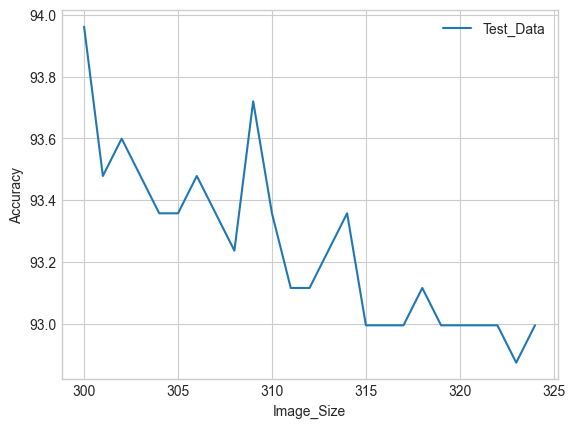

In [32]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [23]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.7917  | 0.826  | 0.809 |          |
|  bcc   |   0.6571  | 0.885  | 0.754 |          |
|  bkl   |   0.9074  | 0.742  | 0.817 |          |
|   df   |    1.0    | 0.167  | 0.286 |          |
|  mel   |   0.8519  | 0.676  | 0.754 |          |
|   nv   |   0.9688  | 0.985  | 0.977 |          |
|  vasc  |   0.6923  |  0.9   | 0.783 |          |
| Total: |           |        |       |  0.9384  |
+--------+-----------+--------+-------+----------+


In [34]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

In [24]:
torch.cuda.memory.empty_cache()
time.sleep(300)

In [ ]:
#test with another test dataset

# network.load_state_dict(torch.load(save_PATH))
# # dict_test = {}
# # dict_size = {}
# test_doc = "test525png299"
# for k in range(24,26):
#     T_size = k
#     for i in range(310,325):      
#         get_data(i)
#         print(f"size:{i}")
#         for j in range(9):
#             test()
#             if dict_size.get(i) is None or dict_size[i] < test_acc:
#                 dict_size[i] = test_acc

#                 if dict_test.get(k) is None or dict_test[k] < test_acc:
#                     dict_test[k] = test_acc

#             elif dict_test.get(k) is None or dict_test[k] < test_acc:
#                     dict_test[k] = test_acc

In [27]:
show.conclusion(img_title=img_title) 
print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [503]
[Test] ACC:93.96%.


NameError: name 'dict_size' is not defined

In [28]:
draw_size_acc(dict_size,custom_path='./tmp',img_title=img_title,suf=suf)

NameError: name 'dict_size' is not defined

In [54]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.8462  | 0.957  | 0.898 |          |
|  bcc   |    0.84   | 0.808  | 0.824 |          |
|  bkl   |   0.9014  |  0.97  | 0.934 |          |
|   df   |    1.0    | 0.167  | 0.286 |          |
|  mel   |   0.7714  | 0.794  | 0.783 |          |
|   nv   |   0.9894  | 0.983  | 0.986 |          |
|  vasc  |   0.9091  |  1.0   | 0.952 |          |
| Total: |           |        |       |  0.9626  |
+--------+-----------+--------+-------+----------+


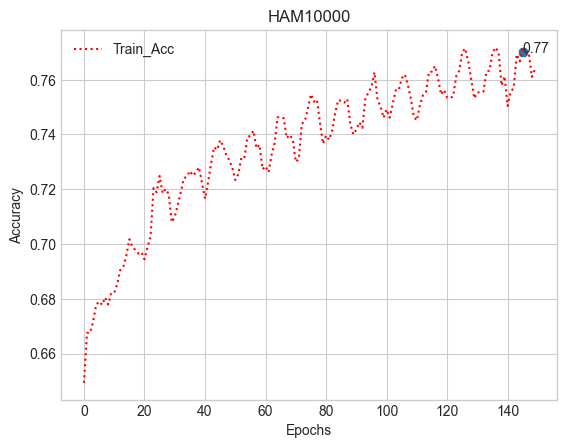

In [36]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

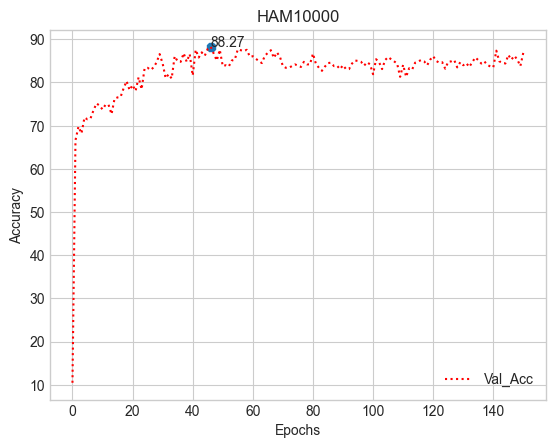

In [37]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

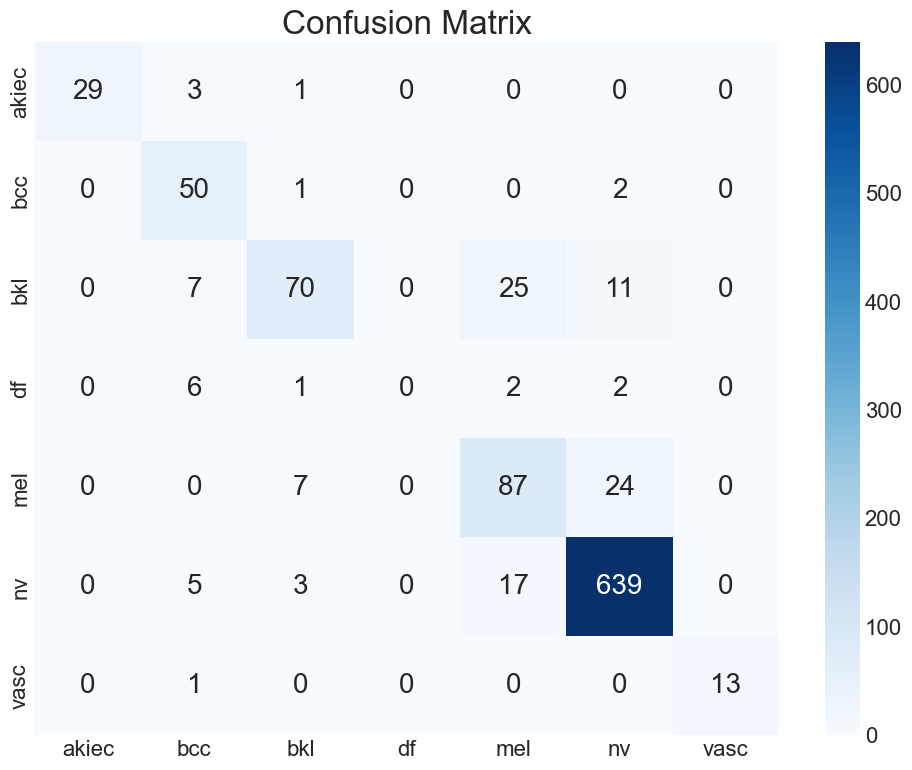

In [38]:
confusion_matrix(val_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

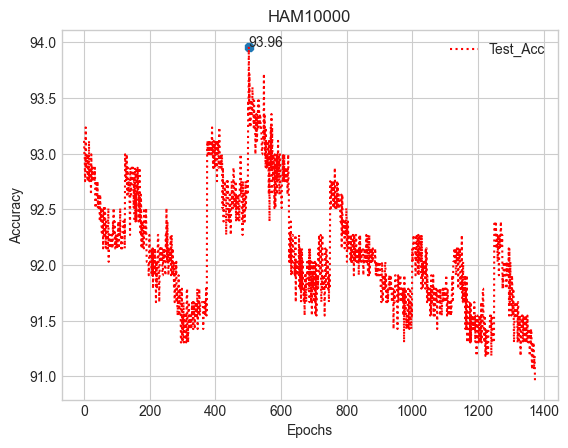

In [39]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

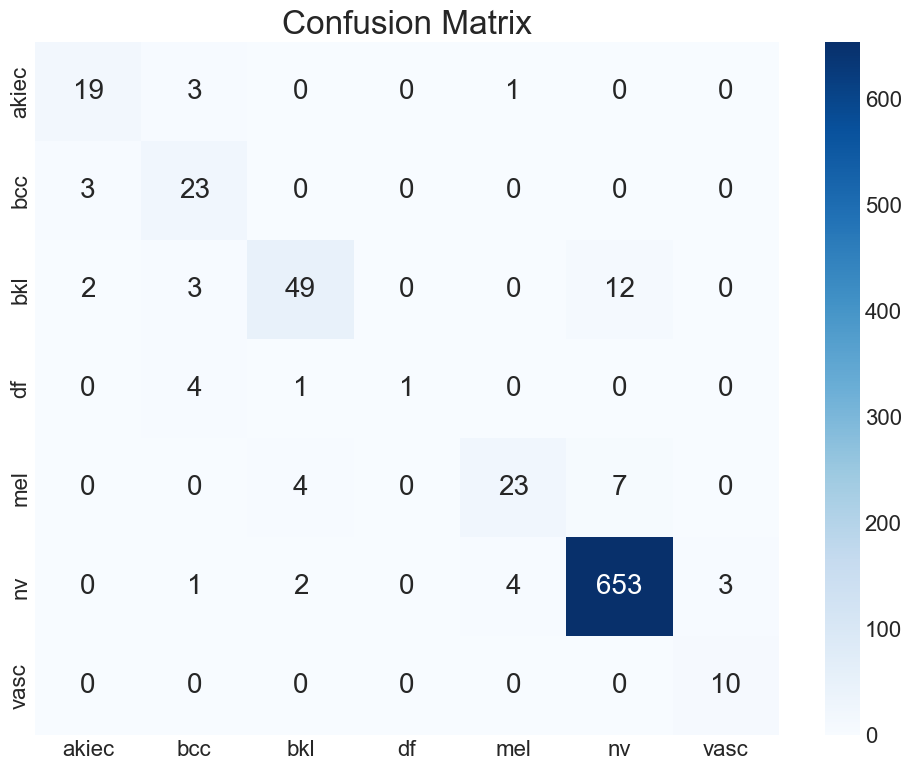

In [40]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

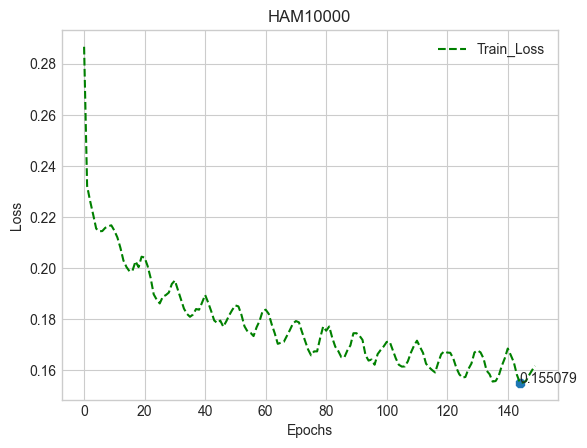

In [41]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
# network.load_state_dict(torch.load(save_PATH))
# dummy_input = torch.randn(1, 3, 299, 299,dtype=torch.float).to(device)
# starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
# repetitions = 300
# timings=np.zeros((repetitions,1))
# #GPU-WARM-UP
# for _ in range(10):
#     _ = network(dummy_input)
#     # MEASURE PERFORMANCE
#     with torch.no_grad():
#         for rep in range(repetitions):
#             starter.record()
#             _ = network(dummy_input)
#             ender.record()
#             # WAIT FOR GPU SYNC
#             torch.cuda.synchronize()
#             curr_time = starter.elapsed_time(ender)
#             timings[rep] = curr_time
#     mean_syn = np.sum(timings) / repetitions
#     std_syn = np.std(timings)
#     mean_fps = 1000. / mean_syn
#     print(' * Mean@1 {mean_syn:.3f}ms Std@5 {std_syn:.3f}ms FPS@1 {mean_fps:.2f}'.format(mean_syn=mean_syn, std_syn=std_syn, mean_fps=mean_fps))
#     print(mean_syn)